In [2]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes,  TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.algorithms.classifiers import VQC, QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA


In [5]:
!pip install -r requirements.txt

     ------------------------------------ 133.7/133.7 kB 875.6 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     -------------------------------------- 163.0/163.0 kB 1.4 MB/s eta 0:00:00
     -------------------------------------- 100.4/100.4 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 3.1/3.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 4.8/4.8 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 3.9 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 4.1/4.1 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with st

ERROR: Ignored the following versions that require a different python version: 0.13.0 Requires-Python >=3.10; 8.19.0 Requires-Python >=3.10; 8.20.0 Requires-Python >=3.10; 8.21.0 Requires-Python >=3.10; 8.22.0 Requires-Python >=3.10; 8.22.1 Requires-Python >=3.10; 8.22.2 Requires-Python >=3.10; 8.23.0 Requires-Python >=3.10; 8.24.0 Requires-Python >=3.10; 8.25.0 Requires-Python >=3.10; 8.26.0 Requires-Python >=3.10; 8.27.0 Requires-Python >=3.10; 8.28.0 Requires-Python >=3.10; 8.29.0 Requires-Python >=3.10; 8.30.0 Requires-Python >=3.10; 8.31.0 Requires-Python >=3.10; 8.32.0 Requires-Python >=3.10; 8.33.0 Requires-Python >=3.10; 8.34.0 Requires-Python >=3.10; 8.35.0 Requires-Python >=3.10; 8.36.0 Requires-Python >=3.10; 8.37.0 Requires-Python >=3.10; 9.0.0 Requires-Python >=3.11; 9.0.0b1 Requires-Python >=3.11; 9.0.0b2 Requires-Python >=3.11; 9.0.1 Requires-Python >=3.11; 9.0.2 Requires-Python >=3.11; 9.1.0 Requires-Python >=3.11; 9.2.0 Requires-Python >=3.11; 9.3.0 Requires-Python >=3

In [3]:
#===================================================================================================================================
import seaborn as sns
from openpyxl import Workbook, load_workbook
import string

#===================================================================================================================================
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import*
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
#==================================================================================================================================
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
#===================================================================================================================================
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd 
import random
import os



ModuleNotFoundError: No module named 'imblearn'

In [ ]:
from qiskit_aer import Aer

simulator = Aer.get_backend('aer_simulator')
simulator.set_options(device='GPU', blocking_qubits=23, blocking_enable=True)

In [ ]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]


In [ ]:
def kernel(x, y, feature_Map_, n_features, entanglement,batch_size, simulator, reps = 1, initial_state=  None, savefig = False, insert_barriers = True  ,parameter_prefix = "$\\theta$"):
	
    sampler = Sampler()
    
    training_params = ParameterVector("θ", 1)
    
    
    fidelity = ComputeUncompute(sampler = sampler)
    # Set up the optimizer
    cb_qkt = QKTCallback()
    spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)
    
    if feature_Map_ == 'ZZFeatureMap':
        fm0 = QuantumCircuit(n_features)
        for i in range(n_features):
            fm0.ry(training_params[0],i)
        # Use ZZFeatureMap to represent input data
        fm1 = ZZFeatureMap(n_features)

        # Create the feature map, composed of our two circuits
        fm = fm0.compose(fm1)

        quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)
   
        # Instantiate a quantum kernel trainer.
        qkt = QuantumKernelTrainer(
             quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
             )
        # Train the kernel using QKT directly
        qka_results = qkt.fit(x, y)
        qkernel = qka_results.quantum_kernel

        if savefig == True:
            fm.decompose().draw('mpl')
            plt.savefig("compilacoes/Experimento_2/Circuitos/" + "ZZfeatureMap" + f"{n_features} qubits" + f" {entanglement}"  + ".png")
        else:
            None
        
    elif feature_Map_ == 'RealAmplitudes':
        n_features = int(n_features/2)
        fm0 = QuantumCircuit(n_features)
        for i in range(n_features):
            fm0.ry(training_params[0],i)
        fm1 =  RealAmplitudes(num_qubits = n_features, entanglement = entanglement, reps=reps, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, initial_state = initial_state)
        
        # Create the feature map, composed of our two circuits
        fm = fm0.compose(fm1)
        feature_Map = RealAmplitudes(num_qubits = int(n_features/2), entanglement = entanglement, reps=reps, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, initial_state = initial_state)
        quant_kernel = TrainableFidelityQuantumKernel(feature_map = fm, training_parameters=training_params)
        # Instantiate a quantum kernel trainer.
        qkt = QuantumKernelTrainer(
            quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
            )
        # Train the kernel using QKT directly
        qka_results = qkt.fit(x, y)
        qkernel = qka_results.quantum_kernel
        if savefig == True:
            fm.decompose().draw('mpl')
            plt.savefig("compilacoes/Experimento_2/Circuitos/"+"Real Amplitudes" + f"{n_features/2} qubits" + f" {entanglement}"  + ".png")
        else:
            None
    elif feature_Map_ == 'EfficientSU2':
        n_features = int(n_features/4)
        fm0 = QuantumCircuit(n_features)
        for i in range(n_features):
            fm0.ry(training_params[0],i)
        fm1 = EfficientSU2(num_qubits = n_features, su2_gates = None, entanglement = entanglement, reps=reps, parameter_prefix=parameter_prefix, insert_barriers=insert_barriers, initial_state = initial_state)

        # Create the feature map, composed of our two circuits
        fm = fm0.compose(fm1)

        
        quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)
        # Instantiate a quantum kernel trainer.
        qkt = QuantumKernelTrainer(
             quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
             )
        # Train the kernel using QKT directly
        qka_results = qkt.fit(x, y)
        qkernel = qka_results.quantum_kernel
        if savefig == True:
            fm.decompose().draw('mpl')
            plt.savefig("compilacoes/Experimento_2/Circuitos/"+"EfficientSU2" + f"{n_features/4} qubits" + f" {entanglement}"  + ".png")
        else:
            None
    
    else:
        print("Feature Map desconhecido")
    
    return fm, qkernel



def resultsQ(y_true,y_pred, feature_map, n_features, entanglement, average , savefig = False):
    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm, 
                         index = ['FF','EF','NF','AF','GF', 'MF' ], 
                         columns = ['FF','EF','NF','AF','GF', 'MF' ])

    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True)
    title ="Kernell: Quântico " + str(feature_map)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    resultQ = pd.DataFrame({"Accuracy": round(accuracy_score(y_true, y_pred)*100,3),"Precision": round(precision_score(y_true, y_pred, average=average)*100,3),"Recall": round(recall_score(y_true, y_pred, average=average)*100,3),"F1_Score": round(f1_score(y_true, y_pred,average=average)*100,3),}, index = range(4)).head(1)
  
    
    if savefig == True:
        plt.savefig('compilacoes/Experimento_2/Matrizes_de_confusao/Quantum/' + feature_map + " " + str(n_features)+ " features" +  " com"  + " qubits " + str(entanglement) + str(fail))
        resultQ = pd.DataFrame({"Accuracy": round(accuracy_score(y_true, y_pred)*100,3),"Precision": round(precision_score(y_true, y_pred, average=average)*100,3),"Recall": round(recall_score(y_true, y_pred, average=average)*100,3),"F1_Score": round(f1_score(y_true, y_pred, average=average)*100,3),}, index = range(4)).head(1).to_csv('compilacoes/Experimento_1/Resultados/Quantum/' + feature_map + " " + str(n_features)+ " features" +  " com"  + " qubits " + str(entanglement) + str(fail))
    

    return resultQ


def resultsC(y_true,y_pred, feature_map, average, savefig = False):
    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm, 
                         index = ['FF','EF','NF','AF','GF', 'MF' ], 
                         columns = ['FF','EF','NF','AF','GF', 'MF' ])

    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True)
    title ="Kernell: Clássico " + str(feature_map)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    resultC = pd.DataFrame({"Accuracy": round(accuracy_score(y_true, y_pred)*100,3),"Precision": round(precision_score(y_true, y_pred, average=average)*100,3),"Recall": round(recall_score(y_true, y_pred, average=average)*100,3),"F1_Score": round(f1_score(y_true, y_pred, average=average)*100,3),}, index = range(4)).head(1)
    
    if savefig == True:
        plt.savefig('compilacoes/Experimento_2/Matrizes_de_confusao/Classical/' + "Kernel_Classico " + str(feature_map) + str(fail))
        resultC = pd.DataFrame({"Accuracy": round(accuracy_score(y_true, y_pred)*100,3),"Precision": round(precision_score(y_true, y_pred, average=average)*100,3),"Recall": round(recall_score(y_true, y_pred, average=average)*100,3),"F1_Score": round(f1_score(y_true, y_pred, average=average)*100,3),}, index = range(4)).head(1).to_csv('compilacoes/Experimento_1/Resultados/Classical/' + "Kernel_Classico" + str(feature_map) + str(fail) )
        
    
    return resultC


def feature_selectionRFE(max_iter,data,X, y, numbers_features):
    std = StandardScaler()
    X = std.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter)
    rfe = RFE(model,n_features_to_select=numbers_features)
    fit = rfe.fit(X,y)
    cols = fit.get_support(indices=True)
    features = data.iloc[:,cols]
    
    return features, cols

def distribution(df_train,savefig = False):
    plt.figure(figsize=[5,5])
    plt.pie(df_train['Fault'].value_counts(), autopct='%.1f', labels=df_train['Fault'].value_counts().keys())
    plt.title(f"Distribution of classes {list(df_train['Fault'].value_counts().keys())}")
    if savefig == savefig:
        plt.savefig("compilacoes/Experimento_2/Distribuicao_treino_test/" + f"Distribution_of_class {list(df_train['Fault'].value_counts().keys())}")
    
    
    return plt.show()





(49134, 69)


/tmp/ipykernel_86114/3556816641.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_NF = int(round(num_NF, 0))


<Axes: title={'center': 'Faults Distribution'}, ylabel='count'>

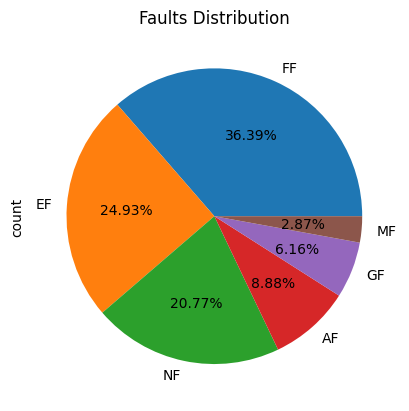

In [ ]:
#======================================================= Parâmetros dos experimentos============================================================================
filename = "df_combine.csv"
path = os.path.join(os.getcwd(), 'compilacoes/data_exp_prepare')
df_combine = pd.read_csv(os.path.join(path, filename), low_memory=False)
df_combine.Fault.value_counts()
#fault= [['Fault',]]
fault =[['AF',]]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
savefig = False # Salvar Figuras
random_state = 45
numbers_features = 8 # Numeros de Features para serem selecionadas
batch_size = 400 # Tamanho dos batchs para treino
qLayers = 1  # Número de camadas do circuito quântico
perc_F_NF = 0.3  # Relação de falha com não falha
res_C = []
res_Q  = []
result_kernel = []
i = 0
#=================================================================================================================================================================

print(df_combine.shape)
df_nf = df_combine[df_combine.Fault=='NF']
df_f = df_combine[df_combine.Fault !='NF']


num_NF = (df_f['Fault'].value_counts()[fault[i]] - perc_F_NF*df_f['Fault'].value_counts()[fault[i]])/perc_F_NF
num_NF = int(round(num_NF, 0))
#print(num_NF)

df_nf = df_combine[df_combine.Fault=='NF'].sample(num_NF, replace=True ,random_state=random_state) # SELECIONANDO 300 SAMPLES DE CASOS DE NÃO FALHA
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 
                                    'WEC: Production minutes', 'DateTime_y'])


#df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])| (df['Fault'] == fault[0][1])| (df['Fault'] == fault[0][2])| (df['Fault'] == fault[0][3])| (df['Fault'] == fault[0][4])]
#df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])]
df['Fault'].value_counts().plot.pie(autopct = '%.2f%%', title = 'Faults Distribution')

In [ ]:
resultQ = []
resultC = []

df = df.sample(len(df))
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
le = LabelEncoder()
y = le.fit_transform(y)

for i in range(len(y)):
    if y[i] == 0:
        y[i] = 1
    elif y[i] == 1:
        y[i] = 0
        
        
df_combine.Fault.value_counts()

Fault
FF    254
EF    174
NF    145
AF     62
GF     43
MF     20
Name: count, dtype: int64

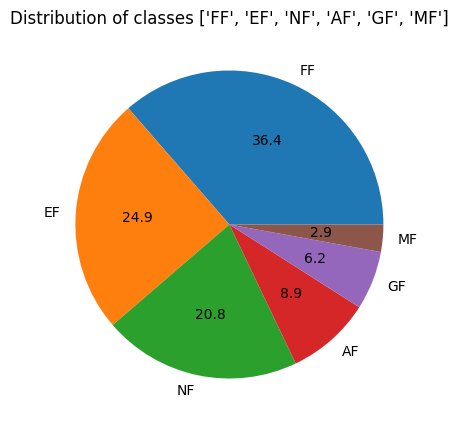

Quantidade de DADOS DE FALHA/NAOFALHA Fault
FF    254
EF    174
NF    145
AF     62
GF     43
MF     20
Name: count, dtype: int64


Quantidade de DADOS TOTAL 698
Porcentagem de DADOS PARA TREINO 70.0%
Porcentagem de DADOS PARA TESTE 30.0%
FORMATO X_train: (488, 8)
FORMATO X_test: (210, 8)
Formato y_train: (488,)
Formato y_test: (210,)
Quantidade de FEATURES: 8


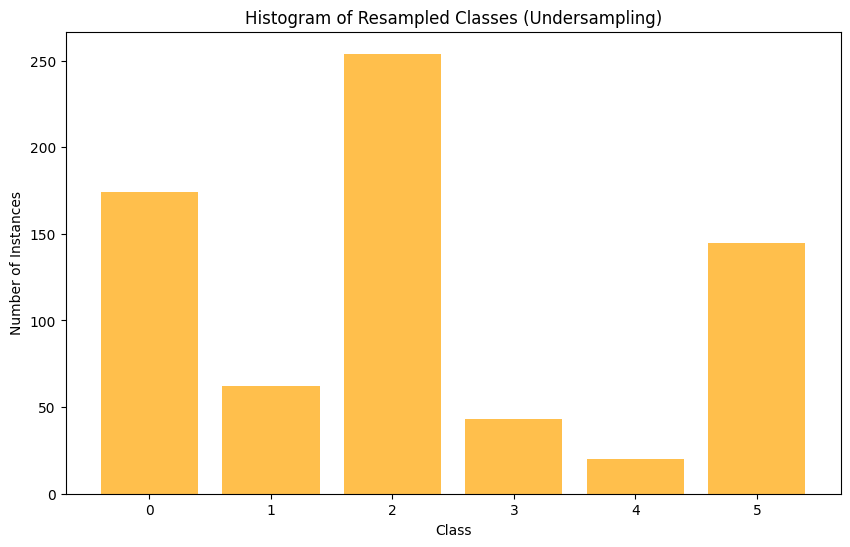

In [ ]:

distribution(df)


X_RFE = feature_selectionRFE(max_iter=500, data = df, X=X, y=y, numbers_features=numbers_features)
X = X_RFE[0] 

# Apply undersampling using RandomUnderSampler
#undersampler = RandomUnderSampler(sampling_strategy='all', random_state=42)
#X, y = undersampler.fit_resample(X, y)


test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state= random_state)




print("Quantidade de DADOS DE FALHA/NAOFALHA", df.Fault.value_counts())
print("\n")
print("Quantidade de DADOS TOTAL", df.Fault.shape[0])
print(f"Porcentagem de DADOS PARA TREINO {(1-test_size)*100}%")
print(f"Porcentagem de DADOS PARA TESTE {(test_size)*100}%")
print(f"FORMATO X_train: {X_train.shape}\nFORMATO X_test: {X_test.shape}\nFormato y_train: {y_train.shape}\nFormato y_test: {y_test.shape}")
n_features = X.shape[1]
print("Quantidade de FEATURES:", n_features)

# Print the histogram of the resampled classes
plt.figure(figsize=(10, 6))
plt.hist(y, bins=range(7), align='left', rwidth=0.8, color='orange', alpha=0.7)
plt.title("Histogram of Resampled Classes (Undersampling)")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
#plt.xticks(range(3), ['Class 0', 'Class 1', 'Class 2'])
plt.show()





In [ ]:
# Scalling
std = StandardScaler()
X_train_prep = pd.DataFrame(std.fit_transform(X_train))
X_test_prep = pd.DataFrame(std.fit_transform(X_test))
#print(y_train.shape)  # Check the shape of y_train


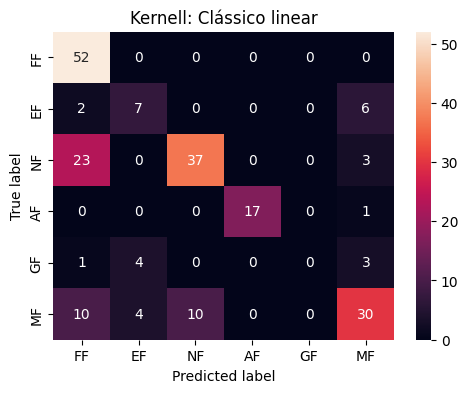

kernel Clássico


[   Accuracy  Precision  Recall  F1_Score
 0    68.095     68.095  68.095    68.095]

In [ ]:
classical_kernels = 'linear' # Define o kernel clássico
svc_classical = SVC(C=2,kernel=classical_kernels, class_weight={0: 0.364, 1: 0.249, 2:0.208, 3: 0.089, 4:0.062, 5:0.29})
svc_classical.fit(X_train_prep, y_train)
y_Cpreds = svc_classical.predict(X_test_prep)
resultC.append(resultsC(y_test, y_Cpreds, feature_map=classical_kernels, average='micro', savefig=False )) # Plota os resultados do kernel clássico


print("kernel Clássico")
display(resultC)


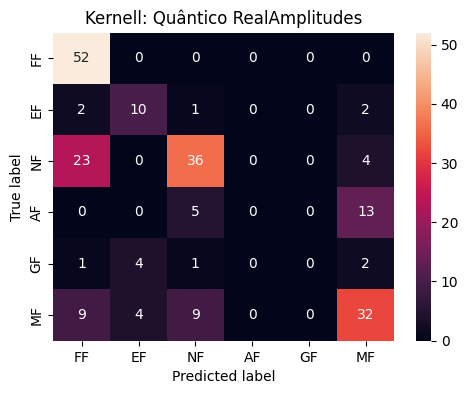

kernel Quântico


[   Accuracy  Precision  Recall  F1_Score
 0    61.905     61.905  61.905    61.905]

In [ ]:
#quantum_kernels = 'ZZFeatureMap' # Define o kernel quântico
quantum_kernels = 'RealAmplitudes' # Define o kernel quântico
#quantum_kernels = 'EfficientSU2' # Define o kernel quântico

entanglement = 'full'

feature_map, qKernel = kernel(X_train_prep, y_train, feature_Map_ = quantum_kernels, n_features = n_features, entanglement = entanglement, batch_size=batch_size, simulator = 'statevector_simulator', reps = qLayers, savefig=False)
#svc_quantum = SVC(C=2,kernel = qKernel.evaluate, class_weight={0:40})
#svc_quantum.fit(X_train_prep, y_train)
#y_Qpreds = svc_quantum.predict(X_test_prep)

# Use QSVC for classification
qsvc = QSVC(quantum_kernel=qKernel, class_weight={0: 0.364, 1: 0.249, 2:0.208, 3: 0.089, 4:0.062, 5:0.29})
# Fit the QSVC
qsvc.fit(X_train_prep, y_train)

# Predict the labels
y_Qpreds = qsvc.predict(X_test_prep)

resultQ.append(resultsQ(y_test, y_Qpreds, feature_map=quantum_kernels, entanglement=entanglement, n_features = n_features, average='micro', savefig=False )) # Função plota os resultados do kernel quântico
print("kernel Quântico")
display(resultQ)

In [ ]:
# Salvar resultado
with open("result.txt", "w") as f:
    f.write(f"QSVC Accuracy: {acc * 100:.2f}%")